# Описание проекта

Аналитика популярного сервиса аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
  - абонентская плата отсутствует;
  - стоимость одной минуты поездки — 8 рублей;
  - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
  - абонентская плата — 199 рублей в месяц;
  - стоимость одной минуты поездки — 6 рублей;
  - стоимость старта — бесплатно.

## Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.

### Пользователи — `users_go.csv`

- `user_id`	уникальный идентификатор пользователя
- `name`	имя пользователя
- `age`	возраст
- `city`	город
- `subscription_type`	тип подписки (free, ultra)

### Поездки — `rides_go.csv`

- `user_id`	уникальный идентификатор пользователя
- `distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration`	продолжительность сессии (в минутах) — время с того момента, как - пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date`	дата совершения поездки

### Подписки — `subscriptions_go.csv`

- `subscription_type`	тип подписки
- `minute_price`	стоимость одной минуты поездки по данной подписке
- `start_ride_price`	стоимость начала поездки
- `subscription_fee`	стоимость ежемесячного платежа

## Оглавление

1. [Загрузка данных](#start)
2. [Предобработка данных](#preparation)
3. [Исследовательский анализ данных](#eda)
4. [Объединение данных](#merge)
5. [Подсчёт выручки](#revenue)
6. [Проверка гипотез](#hypoteses)
7. [Распределения](#spread)
8. [Выводы и рекомендации](#conclusion)

<a id="start"></a>
## Загрузка данных

Считаем CSV-файлы с данными, выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме.

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime, timedelta
import numpy as np
from scipy import stats as st
from math import factorial, sqrt




# зададим стиль по-умолчанию для графиков
plt.style.use('ggplot')

In [2]:
# загружаем CSV-файлы с данными и сохраняем их в датафреймы
try:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    users = pd.read_csv('../datasets/users_go.csv')
    rides = pd.read_csv('../datasets/rides_go.csv')
    subscriptions = pd.read_csv('../datasets/subscriptions_go.csv')

In [3]:
# Выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме
def print_df_heads(df):
    """Выводит первые строки каждого набора данных из переданного списка
    
    :param list df: Список для работы.
    """
    for id, item in enumerate(df):
        try:
            print(f'dataframe {id} \n\n', item.head())
            print ('')
            print(item.info())
            print ('')
        except:
            print('Невозможно вывести информацию')

print_df_heads([users, rides, subscriptions])

dataframe 0 

    user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None

dataframe 1 

    user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1 

### Промежуточные итоги

- `users`: 1565 записей (проверить на дубликаты), пропусков нет, типы данных корректные
- `rides`: 18068 записей (поездок)(проверить на дубликаты), пропусков нет, для даты нужно сменить тип данных
- `subscriptions`: две записи, соответствуют данным в описании

<a id="spreparationtart"></a>
## Предобработка данных

- 2.1 Приведём столбец `date` к типу даты pandas.
- 2.2 Создадим новый столбец с номером месяца на основе столбца `date`.
- 2.3 Проверим наличие пропущенных значений и дубликатов в датафреймах. 

In [4]:
# Приведём столбец `date` к типу даты pandas.
rides['date'] = pd.to_datetime(rides['date'])
rides.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

In [5]:
# Создадим новый столбец с номером месяца на основе столбца `date`.
# в данных только 2021 год, поэтому хранить можно только месяц без указания года
rides['month'] = rides['date'].dt.month
rides['month'].value_counts()

1     1585
5     1560
6     1553
3     1544
7     1529
12    1527
8     1518
9     1517
4     1506
10    1475
11    1418
2     1336
Name: month, dtype: int64

In [6]:
#Проверим наличие пропущенных значений и дубликатов в датафреймах. 
def duplicates_empty_values(df):
    """Выводит количество пропусков и полных дубликатов каждого набора данных из переданного списка
    
    :param list df: Список для работы.
    """
    for id, item in enumerate(df):
        try:
            print(f'dataframe {id} \n\n', f'Количество дубликатов: {item.duplicated().sum()}')
            print ('')
            print(item.isna().sum())
            print ('')
        except:
            print('Невозможно вывести информацию')

duplicates_empty_values([users, rides, subscriptions])

dataframe 0 

 Количество дубликатов: 31

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

dataframe 1 

 Количество дубликатов: 0

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

dataframe 2 

 Количество дубликатов: 0

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64



In [7]:
# Нашлись дубликаты в таблице пользователей 
duplicateRows = users[users.duplicated(keep=False)]
duplicateRows.sort_values(by='user_id')

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra
...,...,...,...,...,...
1554,1198,Демид,29,Ростов-на-Дону,free
1558,1237,Евгения,23,Тюмень,free
1236,1237,Евгения,23,Тюмень,free
1544,1245,Регина,27,Пятигорск,free


In [8]:
users = users.drop_duplicates()
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


### Промежуточные итоги
- Привели столбец `date` к типу даты pandas.
- Создали новый столбец с номером месяца на основе столбца `date`.
- Проверили наличие пропущенных значений (их нет) и дубликатов в датафреймах. Нашли и удалили дубликаты в таблице пользователей

<a id="eda"></a>
## Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:
- 3.1 частота встречаемости городов;
- 3.2 соотношение пользователей с подпиской и без подписки;
- 3.3 возраст пользователей;
- 3.4 расстояние, которое пользователь преодолел за одну поездку;
- 3.5 продолжительность поездок.

In [9]:
# частота встречаемости городов;

city_count = users['city'].value_counts()
city_count


Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

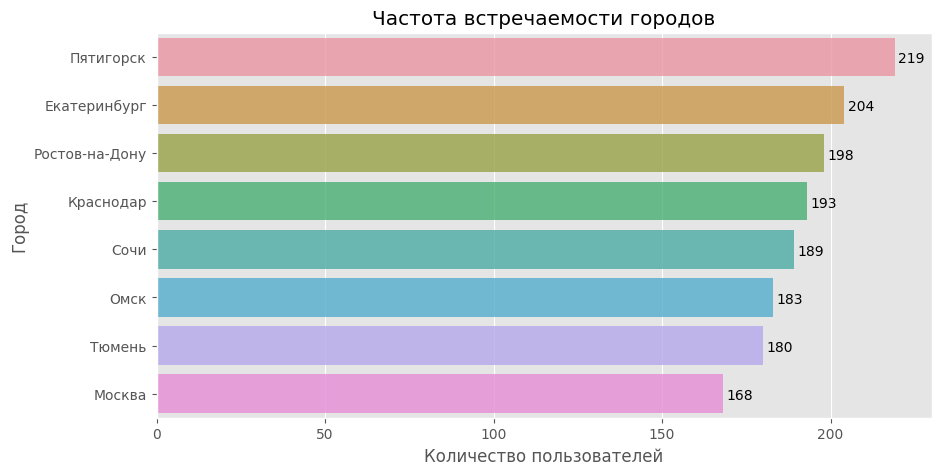

In [10]:
# Plotting a bar graph of the number of users in each city, listed in the column 'city'
plt.figure(figsize=(10,5))
splot = sns.barplot(y=city_count.index, x=city_count.values, alpha=0.8)

for p in splot.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{0:g}'.format(width),
             ha='center', va='center')

plt.title('Частота встречаемости городов')
plt.ylabel('Город', fontsize=12)
plt.xlabel('Количество пользователей', fontsize=12)

plt.show()

In [11]:
# соотношение пользователей с подпиской и без подписки;
subscription_users = users.groupby('subscription_type')['user_id'].agg('count')
subscription_users

subscription_type
free     835
ultra    699
Name: user_id, dtype: int64

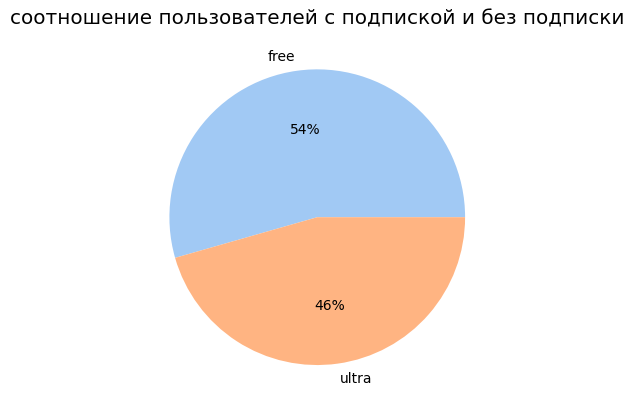

In [12]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(subscription_users.values, labels = subscription_users.index, colors=colors, autopct='%.0f%%')

plt.title('соотношение пользователей с подпиской и без подписки')
plt.show()

In [13]:
# возраст пользователей;

user_age = users['age'].value_counts().sort_index()
user_age

12      4
13      8
14      9
15     13
16     19
17     26
18     46
19     47
20     71
21     93
22    119
23    129
24    132
25    145
26    131
27    119
28    112
29     68
30     68
31     48
32     41
33     39
34     19
35     15
36      6
37      2
38      3
39      1
43      1
Name: age, dtype: int64

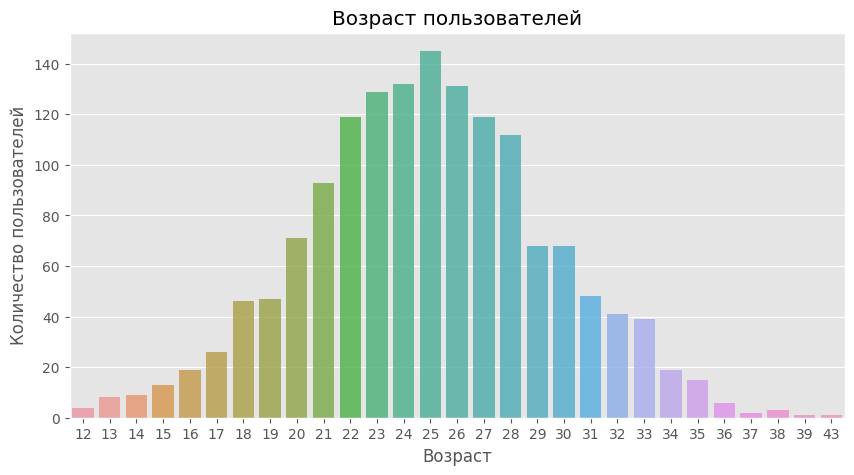

In [14]:
#

plt.figure(figsize=(10,5))
splot = sns.barplot(x=user_age.index, y=user_age.values, alpha=0.8)

plt.title('Возраст пользователей')
plt.ylabel('Количество пользователей', fontsize=12)
plt.xlabel('Возраст', fontsize=12)

plt.show()

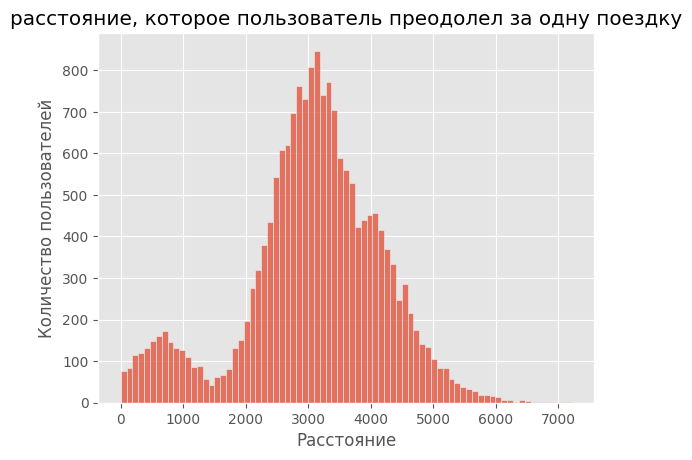

In [15]:
# расстояние, которое пользователь преодолел за одну поездку;

# посмотрим на гистограмму `distance`
sns.histplot(rides['distance'])

plt.title('расстояние, которое пользователь преодолел за одну поездку')
plt.ylabel('Количество пользователей', fontsize=12)
plt.xlabel('Расстояние', fontsize=12)

plt.show()

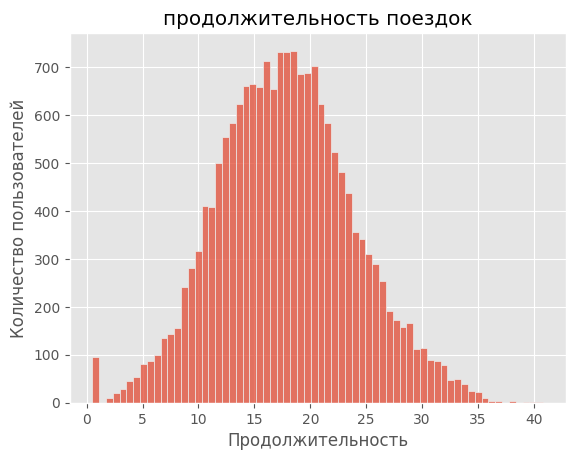

In [16]:
# продолжительность поездок.

# посмотрим на гистограмму `duration`
sns.histplot(rides['duration'])

plt.title('продолжительность поездок')
plt.ylabel('Количество пользователей', fontsize=12)
plt.xlabel('Продолжительность', fontsize=12)

plt.show()

In [17]:
# изучим аномальный выброс на данных, где продолжительность поездки около 0
rides.loc[rides['duration'] < 3]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.500000,2021-08-31,8
6570,704,4830.824371,0.500000,2021-10-14,10
6680,712,4684.004397,0.500000,2021-03-04,3
6691,712,23.963062,2.053251,2021-11-22,11
6695,713,5215.642710,0.500000,2021-02-25,2
...,...,...,...,...,...
17505,1496,5722.551787,0.500000,2021-02-14,2
17663,1507,214.587357,2.495202,2021-05-25,5
17712,1510,166.223109,2.343910,2021-09-06,9
17802,1516,393.696926,2.874882,2021-07-28,7


In [18]:
# видим аномальное значение 0.5 минут при котором дальность поездки высокая
rides.loc[rides['duration'] == 0.5]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


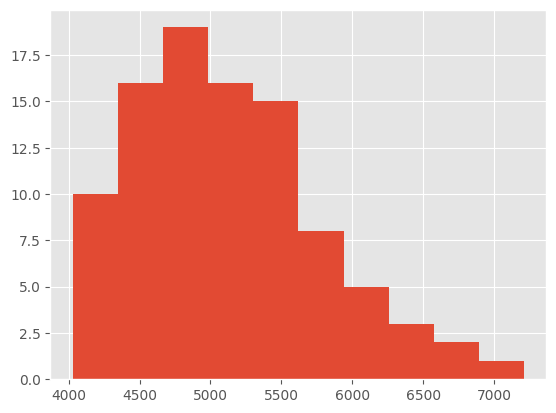

In [19]:
rides.loc[rides['duration'] == 0.5]['distance'].hist()
plt.show()

In [20]:
# удалим эти строки из датасета
rides = rides.drop(rides.loc[rides['duration'] == 0.5].index)

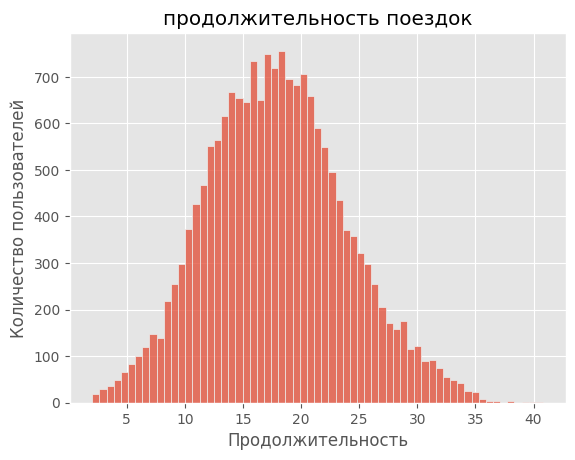

In [21]:
# продолжительность поездок.

# посмотрим на гистограмму `duration`
sns.histplot(rides['duration'])

plt.title('продолжительность поездок')
plt.ylabel('Количество пользователей', fontsize=12)
plt.xlabel('Продолжительность', fontsize=12)

plt.show()

### Промежуточные итоги
1. В датасете 8 городов, разброс пользователей между ними небольшой - от 168 до 219 пользователей
2. Из 1534 пользователей 46% с подпиской и 54% без подписки;
3. возраст пользователей распределён нормально, от 12 до 43 лет
4. расстояние, которое пользователь преодолел за одну поездку — у распределения два пика
  - небольшие поездки до 1км
  - длинные поездки чуть больше 3км
5. продолжительность поездок - распределение нормальное за исключением небольшого пика в области в области 0.5 минут - эти аномальные поездки удалили

<a id="merge"></a>
## Объединение данных

- 4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм.
- 4.2 Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:
  - c данными о пользователях без подписки;
  - с данными о пользователях с подпиской.
- 4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [22]:
# Объединим данные о пользователях, поездках и подписках в один датафрейм
users_subscriptions = users.merge(subscriptions, how='left', on='subscription_type')
df = rides.merge(users_subscriptions, on='user_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [23]:
users_without_sub = df[df['subscription_type'] == 'free']
users_without_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11473 entries, 6500 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   distance           11473 non-null  float64       
 2   duration           11473 non-null  float64       
 3   date               11473 non-null  datetime64[ns]
 4   month              11473 non-null  int64         
 5   name               11473 non-null  object        
 6   age                11473 non-null  int64         
 7   city               11473 non-null  object        
 8   subscription_type  11473 non-null  object        
 9   minute_price       11473 non-null  int64         
 10  start_ride_price   11473 non-null  int64         
 11  subscription_fee   11473 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


In [24]:
users_with_sub = df[df['subscription_type'] == 'ultra']
users_with_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


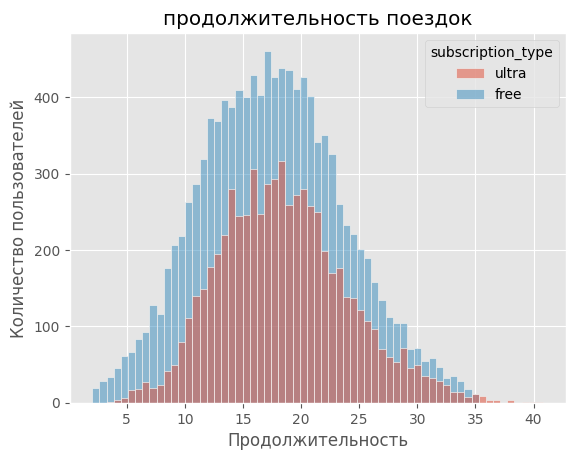

In [25]:
# Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.
sns.histplot(data = df, hue='subscription_type', x='duration')

plt.title('продолжительность поездок')
plt.ylabel('Количество пользователей', fontsize=12)
plt.xlabel('Продолжительность', fontsize=12)

plt.show()

Пользователи с подпиской, судя по графикам, могут делать более длительные поездки - среди них очень мало поездок < 5 минут и есть поездкиболее 35 минут. В целом оба распределения нормальные

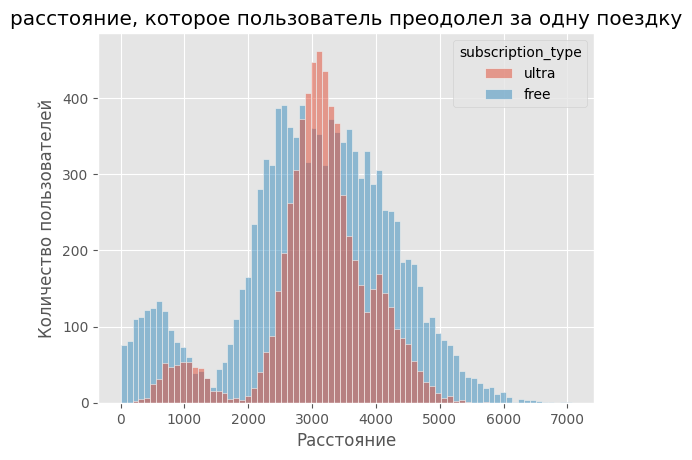

In [26]:
sns.histplot(data = df, hue='subscription_type', x='distance')

plt.title('расстояние, которое пользователь преодолел за одну поездку')
plt.ylabel('Количество пользователей', fontsize=12)
plt.xlabel('Расстояние', fontsize=12)

plt.show()

Распределения похожи, однако тут также у платных пользователей есть отличия - более дальние поездки в левой части (1км), и большее количество пользователей в центральной части колокола.

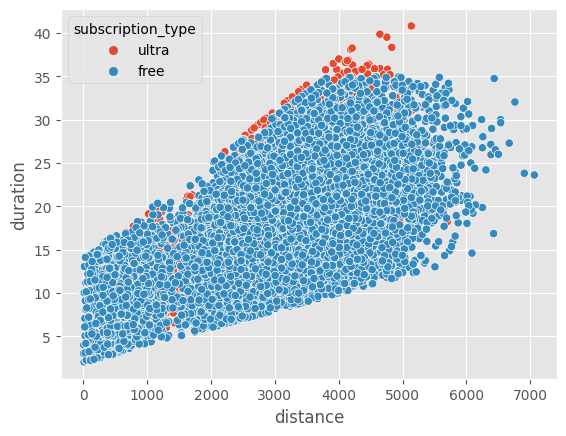

In [27]:
sns.scatterplot(data = df, hue='subscription_type', x='distance', y='duration')

plt.show()

Отличий не очень много, однако есть пользователи с платной подпиской, которые делают наиболее дальние и долгие поездки

### Промежуточные итоги
- Объединили данные о пользователях, поездках и подписках в один датафрейм.
- Визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий:
  - Пользователи с подпиской, судя по графикам, могут делать более длительные поездки - среди них очень мало поездок < 5 минут и есть поездкиболее 35 минут. В целом оба распределения нормальные
  - Распределения по расстоянию похожи, однако тут также у платных пользователей есть отличия - более дальние поездки в левой части (1км), и большее количество пользователей в центральной части колокола.
  - Отличий не очень много, однако есть пользователи с платной подпиской, которые делают наиболее дальние и долгие поездки

<a id="revenue"></a>
## Подсчёт выручки

- 5.1 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
- 5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа. (с помощью метода «потолок» библиотеки numpy — np.ceil())

In [28]:
df.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [29]:
# датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными
df_users = df.groupby(['user_id', 'month']).agg(
    distance = ('distance', 'sum'),
    rides = ('user_id', 'count'),
    duration = ('duration', 'sum'),
    subscription = ('subscription_type', 'first'),
    minute_price = ('minute_price', 'first'),
    start_ride_price = ('start_ride_price', 'first'),
    subscription_fee = ('subscription_fee', 'first')
)

df_users['duration'] = np.ceil(df_users['duration'])
# Помесячная выручка считается по формуле: стоимость старта поездки × количество поездок 
# + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.
df_users['monthly_revenue'] = df_users['start_ride_price'] * df_users['rides'] + df_users['minute_price'] * df_users['duration'] + df_users['subscription_fee']

df_users.head(20)

distance  rides  duration subscription  minute_price  \
user_id month                                                             
1       1       7027.511294      2      42.0        ultra             6   
        4        754.159807      1       7.0        ultra             6   
        8       6723.470560      2      45.0        ultra             6   
        10      5809.911100      2      32.0        ultra             6   
        11      7003.499363      3      54.0        ultra             6   
        12      6751.629942      2      28.0        ultra             6   
2       3      10187.723006      3      61.0        ultra             6   
        4       6164.381824      2      40.0        ultra             6   
        6       3255.338202      1      14.0        ultra             6   
        7       6780.722964      2      47.0        ultra             6   
        8        923.007439      1       7.0        ultra             6   
        10      2824.636598      1      19.0        ultra             6   
        12      3828.248580      1      12.0        ultra             6   
3       1       3061.777147      1      13.0        ultra             6   
        2       5421.152016      2      38.0        ultra             6   
        4       2956.651632      1      21.0        ultra             6   
        5       9064.026918      3      62.0        ultra             6   
        7      10919.595403      3      66.0        ultra             6   
        9       2891.012822      1      23.0        ultra             6   
        12      2593.381928      1      13.0        ultra             6   

               start_ride_price  subscription_fee  monthly_revenue  
user_id month                                                       
1       1                     0               199            451.0  
        4                     0               199            241.0  
        8                     0               199            469.0  
        10                    0               199            391.0  
        11                    0               199            523.0  
        12                    0               199            367.0  
2       3                     0               199            565.0  
        4                     0               199            439.0  
        6                     0               199            283.0  
        7                     0               199            481.0  
        8                     0               199            241.0  
        10                    0               199            313.0  
        12                    0               199            271.0  
3       1                     0               199            277.0  
        2                     0               199            427.0  
        4                     0               199            325.0  
        5                     0               199            571.0  
        7                     0               199            595.0  
        9                     0               199            337.0  
        12                    0               199            277.0

<a id="hypoteses"></a>
## Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.
- 6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 
- 6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
- 6.3 Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
- 6.4 Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест понадобился бы для проверки этой гипотезы?

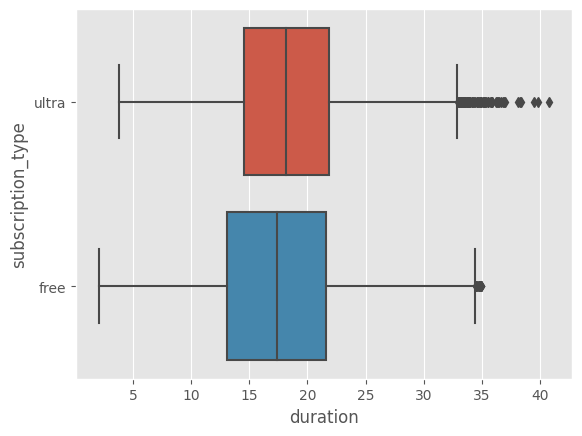

In [30]:
# сначала попробуем посмотреть визуально - тратят ли пользователи с подпиской больше времени на поездки
sns.boxplot(data=df, x='duration', y='subscription_type')
plt.show()

Видим, что длительность поездок пользователей с подпиской действительно в среднем выше

In [31]:
df.groupby('subscription_type')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
subscription_type,,,,,,,,
free,11473.0,17.530771,6.162609,2.035632,13.085688,17.383807,21.638038,34.948498
ultra,6500.0,18.541985,5.572048,3.760353,14.524654,18.178153,21.884129,40.823963


Нулевая гипотеза: средние значения времени в поездках пользователей из двух групп равны.
Альтернативная гипотеза: среднее значение времени в поездках пользователей с подпиской больше, чем среднее значение времени в поездках пользователей без подписки

In [32]:
# пользователи с подпиской
sample_1 = users_with_sub['duration']
#пользователи без подписки
sample_2 = users_without_sub['duration']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.704468074453899e-28
Отвергаем нулевую гипотезу


Считаем, что среднее значение времени в поездках пользователей с подпиской больше, чем среднее значение времени в поездках пользователей без подписки

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
Альтернативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров.

In [33]:
distances = users_with_sub['distance']

optimal_distance = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    distances, 
    optimal_distance,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Гипотезу подтверждаем (так как недостаточно данных, чтобы её опровергнуть) - Можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [34]:
# пользователи с подпиской
sample_1 = df_users[df_users['subscription'] == 'ultra']['monthly_revenue']
#пользователи без подписки
sample_2 = df_users[df_users['subscription'] == 'free']['monthly_revenue']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 3.914474385320123e-34
Отвергаем нулевую гипотезу


Гипотезу подтверждаем - помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Гипотеза о равенстве средних для зависимых (парных) выборок

### Промежуточные 

Проверили несколько гипотез:

- Считаем, что среднее значение времени в поездках пользователей с подпиской больше, чем среднее значение времени в поездках пользователей без подписки
- Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
- Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
- Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. 

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python применяется метод `scipy.stats.ttest_rel()`.

<a id="spread"></a>
## Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 


7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

https://practicum.yandex.ru/trainer/data-analyst-plus/lesson/5afc67ea-39f1-4f50-87ca-9b1c835fc474/

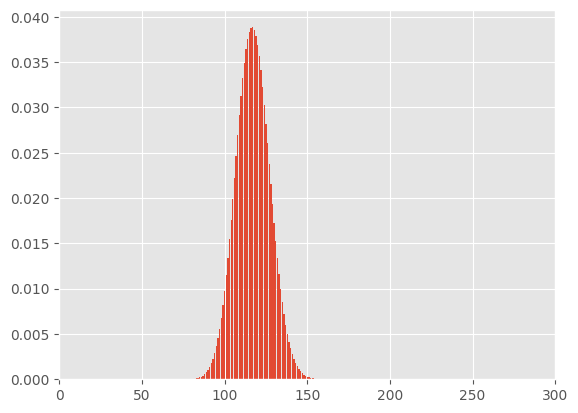

In [35]:
# Подберём параметры распределения, описывающего ситуацию 7.1, построим график распределения и сформулируем ответ на вопрос о количестве промокодов.
# Нужно использовать биномиальное распределение, которое описывает указанную ситуацию. Затем подобрать подходящее значение параметра N для заданного параметра p=0.1 с помощью графиков и метода cdf().

# после бесплатного пробного периода подписку продлевают 10 % пользователей
p = 0.1

# план - 100 клиентов, вероятность не выполнить план должна быть примерно 5 %
n = 1171

# значение, для которого хотим найти вероятность
x = 100

distr = []

for k in range(0, n + 1):
    prob = st.binom.pmf(k, n, p)
    distr.append(prob)
    
plt.bar(range(0, n + 1), distr)
plt.xlim(0,300)
plt.show()

In [36]:
prob = st.binom.cdf(x, n, p)
prob

0.0505235199072141

- Если взять 1000 промокодов - вероятность не выполнить план - 53%
- Если взять 1200 промокодов - вероятность не выполнить план - 2.8%
- Если взять 1100 промокодов - вероятность не выполнить план - 17%
- Если взять 1150 промокодов - вероятность не выполнить план - 7.5%
- Если взять 1171 промокод - вероятность не выполнить план - 5%

In [37]:
#  Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. 
# С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399500
result = distr.cdf(399500)
result

0.15371708296369768

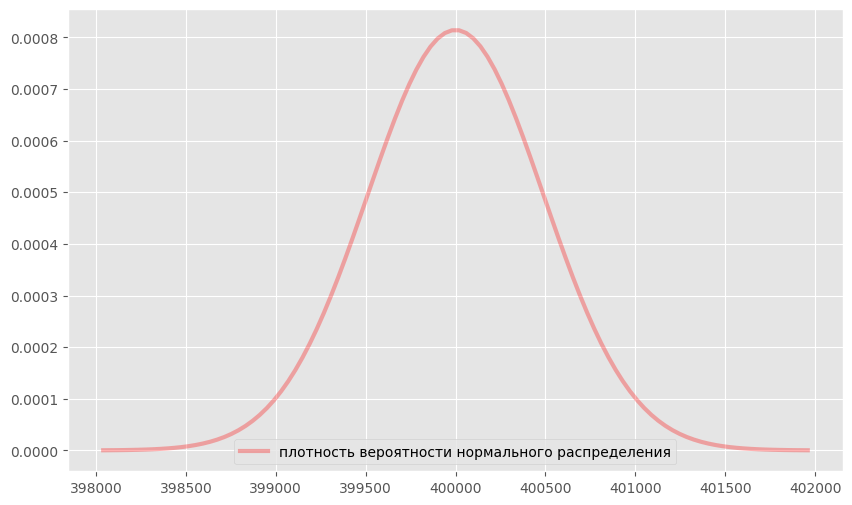

In [38]:
# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
plt.figure(figsize=(10,6))
# рисуем график биномиального распределения
ax = plt.subplot()

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = np.linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, st.norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()

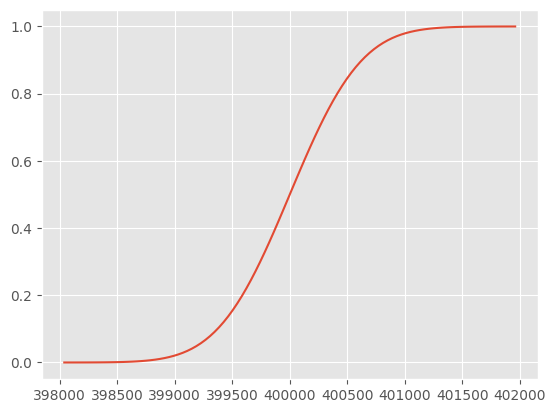

In [39]:
plt.plot(x, st.norm.cdf(x, mu, sigma))
plt.show()

### Промежуточные итоги
- Если взять 1171 промокод - вероятность не выполнить план - 5%
- Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей - 15%

<a id="conclusion"></a>
## Выводы

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках сервиса аренды самокатов GoFast. Необходимо было проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

### Провели предобработку:
- Привели столбец `date` к типу даты pandas.
- Создали новый столбец с номером месяца на основе столбца `date`.
- Проверили наличие пропущенных значений (их нет) и дубликатов в датафреймах. Нашли и удалили дубликаты в таблице пользователей

### Провели исследовательский анализ данных:
1. В датасете 8 городов, разброс пользователей между ними небольшой - от 168 до 219 пользователей
2. Из 1534 пользователей 46% с подпиской и 54% без подписки;
3. возраст пользователей распределён нормально, от 12 до 43 лет
4. расстояние, которое пользователь преодолел за одну поездку — у распределения два пика
  - небольшие поездки до 1км
  - длинные поездки чуть больше 3км
5. продолжительность поездок - распределение нормальное за исключением небольшого пика в области 0.5 минут - эти аномальные поездки удалили

- Объединили данные о пользователях, поездках и подписках в один датафрейм.
- Визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий:
  - Пользователи с подпиской, судя по графикам, могут делать более длительные поездки - среди них очень мало поездок < 5 минут и есть поездкиболее 35 минут. В целом оба распределения нормальные
  - Распределения по расстоянию похожи, однако тут также у платных пользователей есть отличия - более дальние поездки в левой части (1км), и большее количество пользователей в центральной части колокола.
  - Отличий не очень много, однако есть пользователи с платной подпиской, которые делают наиболее дальние и долгие поездки

### Проверили несколько гипотез:

- Считаем, что среднее значение времени в поездках пользователей с подпиской больше, чем среднее значение времени в поездках пользователей без подписки
- Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
- Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
- Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. 

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python применяется метод `scipy.stats.ttest_rel()`.

### Проверили гипотезы отдела маркетинга
- Если взять 1171 промокод - вероятность не выполнить план - 5%
- Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей - 15%